# Guide to Analyze Spike Properties
This file is meant to ilustrate the data collected in each single spike using SpykProps.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/M.Sc/THESIS/ImageAnalysis/SpikeProperties/Spyk_Prop')
sys.path

In [ ]:
pip install skan

# Dependencies

In [1]:
# Import dependencies


from CustomFunctions import *
import os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import glob
import cv2

import math

from skimage.morphology import skeletonize, thin
from skimage import morphology, filters, measure
from skimage import data, segmentation, color
from skimage.future import graph
from skimage.segmentation import watershed, active_contour
from skimage.feature import peak_local_max
from skimage.filters import meijering, sato, frangi, hessian, gaussian
from skimage.color import rgb2gray
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.draw import line

from scipy.interpolate import splprep, splev
from scipy.interpolate import interp1d

from PIL import Image

from skan import Skeleton, summarize, skeleton_to_csgraph, draw

import seaborn as sns

import imutils

import seaborn as sns
import imageio

import random

import pathlib

# import astropy.units as u
# from fil_finder import FilFinder2D
# from astropy.io import fits

# Make sure Jupyter Notebook shows all outputs from the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Change the "%matplotlib inline" figure resolution on the notebook
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

# Functions

## `ListImages`
Returns a list of full image paths.

In [3]:
%%time
def ListImages(path, imgformat=".tif", recursive=False):
    Images = glob.glob(path + '/*' + imgformat, recursive=True)    
    return Images

# Example:
# path = r'./Images/TEST'
# Images = ListImages(path, imgformat=".tif", recursive=False)

Wall time: 0 ns


## `RemoveBackground`
Input can be the image as an array or just the full image path.
It takes almost 25 seconds to create list with five images (rgb, gray, lab, hsv, bw). Needs to be optimized.

In [4]:
%%time
def RemoveBackground(img, OtsuScaling=0.25, rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True):
    
    # Read image
    if isinstance(img, str) == True:
        img0 = plt.imread(img)
    else: 
        img0 = img
    
    # Crop images. They were all taken with the same scanner
    img1 = img0[44:6940, 25:4970, :]
    
     # Convert to gray
    gray0 = img1 @ [0.2126, 0.7152, 0.0722]
    
    # Set image threshold
    T = filters.threshold_otsu(gray0)
#     print(T)
    T = T*OtsuScaling
#     print(T)
    
    # Segment gray image
    bw0 = gray0 > T
    
    # Remove small objects
    n_pixels = gray0.shape[0] * gray0.shape[1]
    minimum_size = n_pixels/10000
    bw1 = morphology.remove_small_objects(bw0, min_size=np.floor(minimum_size))
    
    ImagesOut = []
#     len(ImagesOut)
    
    if rgb_out==True:
        # Apply mask to RGB
        rgb = np.where(bw1[..., None], img1, 0)
        ImagesOut.append(rgb)
    if gray_out==True and rgb_out==True:
        gray = color.rgb2gray(rgb)
        ImagesOut.append(gray)
    if lab_out==True and rgb_out==True:
        lab = color.rgb2lab(rgb)
        ImagesOut.append(lab)
    if hsv_out==True and rgb_out==True:
        hsv = color.rgb2hsv(rgb)
        ImagesOut.append(hsv)
    if bw_out==True:
#         # Threshold
#         otsu = filters.threshold_otsu(gray)
#         bw0 = gray > 0
#         bw = morphology.remove_small_objects(bw0, min_size=1.5e-05 * gray.shape[0] * gray.shape[1])
        ImagesOut.append(bw1)
    
    return ImagesOut

# Usage:
# %%time
# I = RemoveBackground(Images[3], OtsuScaling=0.25, rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
# rgb0 = I[0]
# gray0 = I[1]
# lab0 = I[2]
# hsv0 = I[3]
# bw0 = I[4]


Wall time: 0 ns


## `EnumerateSpkCV`
Enumerate spikes, spikelets, or contours.

In [5]:
%%time
# Enumerate spikes
def EnumerateSpkCV(bw, rgb, TextSize=5, TROE2020=False):
    
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(bw), connectivity=8)
    img = rgb.copy()
    
    if TROE2020==True:
        counter=-1
    else:
        counter=0
        for c in centroids:
    #         print(c)
            cx = round(c[0])
            cy = round(c[1])
            img = cv2.circle(img, (cx, cy), 10, (255, 0, 0), -1)
            img = cv2.putText(img, str(counter), (cx - 25, cy - 25),cv2.FONT_HERSHEY_SIMPLEX, TextSize, (255, 0, 0), 15)
            counter = counter+1
        plt.imshow(img)

# # Example:
# EnumerateSpkCV(bw0, rgb0, TextSize=5, TROE2020=False)
# EnumerateSpkCV(spklts, cropped_rgb, TextSize=5, TROE2020=False)

Wall time: 0 ns


## `spk_length`
Return the spike length

In [6]:
%%time

def spk_length(cropped_spk, method='skelblur', Overlay=True, PlotCH=False):
    
    if method=='skelblur':
        # Severly blur the image
        blur = cv2.blur(np.float32(cropped_spk),(100,100))
        # Threshold the blur
        thrb = blur > 0.1
        skeleton = skeletonize(thrb)
#         plt.imshow(skeleton)
        
    if method=='chull':
        # Blur the image with a 50x50 kernel
        blur = cv2.blur(np.float32(cropped_spk),(50,50))

        # Get convex hull 
        chull = convex_hull_image(blur>0)

        # Perform skeletonization
        image = chull
        skeleton = skeletonize(image)
    #     plt.imshow(skeleton)
    
    # Spike length
    SpkL = cv2.countNonZero(np.float32(skeleton))
    
    if PlotCH == True:
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        ax = axes.ravel()

        ax[0].set_title('Original picture')
        ax[0].imshow(cropped_spk, cmap=plt.cm.gray)
        ax[0].set_axis_off()

        ax[1].set_title('Transformed picture')
        ax[1].imshow(chull, cmap=plt.cm.gray)
        ax[1].set_axis_off()

        plt.tight_layout()
        plt.show()
    
    # Visualize overlay?
    if Overlay == True:
        overlay_images = cv2.addWeighted(np.float32(cropped_spk),20,np.float32(skeleton),255,0)
        plt.imshow(overlay_images, cmap='gray')
    
    return SpkL

# Example:
# SL = spk_length(cropped_spk, method='skelblur', Overlay=True, PlotCH=False)

Wall time: 0 ns


## `PixelHist`
Object histogram analysis. This function returns the black and white version of the given image(s) and print the label of each spike as computed by 'skimage.measure.label'


In [7]:
%%time
def PixelHist(bw, ColorSpace, channel = 0, spikes="All", nbins = 100):
    
    labeled_spks, num_spikes = label(bw, return_num = True)
#     plt.imshow(labeled_spks==0)

    if spikes=="All":
        labeled_spks = labeled_spks
    else:
        for L in range(1,num_spikes+1):
#             print(L)
            if not L in spikes:
#                 print("Deleted label ", L)
                labeled_spks=np.where(labeled_spks==L, 0, labeled_spks)
#     plt.imshow(labeled_spks)
    
    Props = regionprops(labeled_spks, intensity_image=ColorSpace[:,:,channel])
    Areas = [rp.area for rp in Props]
    Labels = [rp.label for rp in Props] #Delete 1 because label in image is +1 greater than ACTUAL label
    Spikes_Data = []
    Names = []
    Colors = sns.color_palette("husl", len(spikes))
    Colors2 = [list(i) for i in Colors] # list of lists
    
    
    for indexed in range(len(Labels)):        
        spk_data = Props[indexed].intensity_image 
        spk_data = spk_data.ravel()
        NonZero = spk_data[spk_data != 0]

        Spikes_Data.append(NonZero)
        Names.append("Spike " + str(int(spikes[indexed])) + "\n" + "Area = "  + str(round(np.mean(NonZero))) + " px" + "\n" +
                     "Mean = "  + str(round(np.mean(NonZero), 1)))
        Colors.append(list(np.random.choice(range(2), size=3)))
    
    plt.hist(Spikes_Data, bins = nbins, color = Colors2, label = Names);
    
    # Plot formatting
    plt.legend();
    plt.xlabel('Intensity Value');
    plt.ylabel('Number of NonZero Pixels');
    plt.title('Distribution of None-Zero Pixel Values for Selected Given Channel and Spikes');

# Example:
PixelHist(bw=bw0, ColorSpace=lab0, channel = 0, spikes=[1,2,26], nbins = 100)

NameError: name 'bw0' is not defined

## `channel_percentiles`
This returns the percentiles for a given channel.

In [25]:
%%time
def channel_percentiles(channel_props, Negatives = None):
      
    # Create empty lists to populate    
    p25_pos_list = []
    p50_pos_list = []
    p75_pos_list = []
    p25_neg_list = []
    p50_neg_list = []
    p75_neg_list = []
    mean_pos_list = []
    sd_pos_list = []
    min_pos_list = []
    max_pos_list = []
    mean_neg_list = []
    sd_neg_list = []
    min_neg_list = []
    max_neg_list = []
    
#     channel_props[1].intensity_image
    

    # channel_props = red_props
    for spk in range(len(channel_props)):
        my_array = channel_props[spk].intensity_image
        flat_array = my_array.ravel()
        non_zero = flat_array[flat_array != 0]

        positive_values = non_zero[non_zero > 0]        
        p25_pos = np.percentile(positive_values, 25)
        p25_pos_list.append(p25_pos)
        p50_pos = np.percentile(positive_values, 50)
        p50_pos_list.append(p50_pos)
        p75_pos = np.percentile(positive_values, 75)
        p75_pos_list.append(p75_pos)
        mean_pos = np.mean(positive_values)
        mean_pos_list.append(mean_pos)
        sd_pos = np.std(positive_values)
        sd_pos_list.append(sd_pos)
        min_pos = min(positive_values)
        min_pos_list.append(min_pos)
        max_pos = max(positive_values)
        max_pos_list.append(max_pos)

        if Negatives == True:
            negative_values = non_zero[non_zero < 0]
            p25_neg = np.percentile(negative_values, 25)
            p25_neg_list.append(p25_neg)
            p50_neg = np.percentile(negative_values, 50)
            p50_neg_list.append(p50_neg)
            p75_neg = np.percentile(negative_values, 75)
            p75_neg_list.append(p75_neg)
            mean_neg = np.mean(negative_values)
            mean_neg_list.append(mean_neg)
            sd_neg = np.std(positive_values)
            sd_neg_list.append(sd_neg)
            min_neg = min(negative_values)
            min_neg_list.append(min_neg)
            max_neg = max(negative_values)
            max_neg_list.append(max_neg)

            Lists = [p25_pos_list, p50_pos_list, p75_pos_list, mean_pos_list, sd_pos_list, min_pos_list, max_pos_list, p25_neg_list, p50_neg_list, p75_neg_list, mean_neg_list, sd_neg_list, min_neg_list, max_neg_list]
        else:
            Lists = [p25_pos_list, p50_pos_list, p75_pos_list, mean_pos_list, sd_pos_list, min_pos_list, max_pos_list]

        
        # if any(pixel < 0 for pixel in non_zero) == True:
        #     negative_values = non_zero[non_zero < 0]
        #     p25_neg = np.percentile(negative_values, 25)
        #     p25_neg_list.append(p25_neg)
        #     p50_neg = np.percentile(negative_values, 50)
        #     p50_neg_list.append(p50_neg)
        #     p75_neg = np.percentile(negative_values, 75)
        #     p75_neg_list.append(p75_neg)
    return Lists


########################################################################################
# Examples:

# For one spike
# labeled_contours, num_contours = label(cropped_spk, return_num = True)
# red_props = regionprops(labeled_contours, intensity_image=cropped_rgb)
# Red_Perc = np.array(channel_percentiles(channel_props=red_props, Negatives=False)).T
# len(Red_Perc)


# For one entire image
# labeled_contours, num_contours = label(bw0, return_num = True)
# red_props = regionprops(labeled_contours, intensity_image=rgb0)
# Red_Perc = np.array(channel_percentiles(channel_props=red_props, Negatives=False)).T
# len(Red_Perc)

Wall time: 0 ns


## `SpikesDF`
Spike properties in a DataFrame. This function returns a Pandas data frame with the geometric and spectral properties of the given path to rgb image

In [9]:
%%time
def SpikesDF(I, ImagePath, RemoveBG=False, PrintSpkLabels=False):
    
    # Check if images or path were given
    if RemoveBG == True:
        # Remove background (path was given)
        I = RemoveBackground(ImagePath, OtsuScaling=0.25, rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
        rgb0 = I[0]
        gray0 = I[1]
        lab0 = I[2]
        hsv0 = I[3]
        bw0 = I[4]
        
        Image_Name = ImagePath.split('\\')[-1]

    else: 
        # Images were given in a list as returned by RemoveBackground()
        rgb0 = I[0]
        gray0 = I[1]
        lab0 = I[2]
        hsv0 = I[3]
        bw0 = I[4]
    
    
    labeled_spks, num_spikes = label(bw0, return_num = True)
    props_spikes = regionprops(labeled_spks)
    
    # Create column with image name
    Image_Name = ImagePath.split('\\')[-1]
    Image_Name = [Image_Name] * num_spikes
    
    # Geometric properties
    Labels = [rp.label for rp in props_spikes]
    Areas = [rp.area for rp in props_spikes]
    MajorAxes = [rp.major_axis_length for rp in props_spikes]
    MinorAxes = [rp.minor_axis_length for rp in props_spikes]
    Orientations = [rp.orientation for rp in props_spikes]
    Perimeters = [rp.perimeter for rp in props_spikes]
    Eccentricities = [rp.eccentricity for rp in props_spikes]
   
    # Spectral properties
    red_props = regionprops(labeled_spks, intensity_image=rgb0[:,:,0])
    green_props = regionprops(labeled_spks, intensity_image=rgb0[:,:,1])
    blue_props = regionprops(labeled_spks, intensity_image=rgb0[:,:,2])
    L_props = regionprops(labeled_spks, intensity_image=lab0[:,:,0])
    a_props = regionprops(labeled_spks, intensity_image=lab0[:,:,1])
    b_props = regionprops(labeled_spks, intensity_image=lab0[:,:,2])
    
    red = np.array([[rp.mean_intensity,rp.min_intensity,rp.max_intensity] for rp in red_props])
    green = np.array([[rp.mean_intensity,rp.min_intensity,rp.max_intensity] for rp in green_props])
    blue = np.array([[rp.mean_intensity,rp.min_intensity,rp.max_intensity] for rp in blue_props])
    L = np.array([[rp.mean_intensity,rp.min_intensity,rp.max_intensity] for rp in L_props])
    a = np.array([[rp.mean_intensity,rp.min_intensity,rp.max_intensity] for rp in a_props])
    b = np.array([[rp.mean_intensity,rp.min_intensity,rp.max_intensity] for rp in b_props])
    
    Red_Perc = np.array(channel_percentiles(red_props, Negatives=False)).T
    Green_Perc = np.array(channel_percentiles(green_props, Negatives=False)).T
    Blue_Perc = np.array(channel_percentiles(blue_props, Negatives=False)).T
    L_Perc = np.array(channel_percentiles(L_props)).T
    a_Perc = np.array(channel_percentiles(a_props, Negatives=True)).T
    b_Perc = np.array(channel_percentiles(b_props, Negatives=True)).T

    # Dataframe 1: for single obervation per spike
    Spikes_per_image = pd.DataFrame(
    list(zip(Image_Name, Labels, Areas, MajorAxes, MinorAxes, Orientations, Eccentricities, Perimeters, 
             red[:,0], red[:,1], red[:,2], green[:,0], green[:,1], green[:,2], blue[:,0], blue[:,1], blue[:,2], 
             L[:,0], L[:,1], L[:,2], a[:,0], a[:,1], a[:,2], b[:,0], b[:,1], b[:,2], 
             Red_Perc[:,0], Red_Perc[:,1], Red_Perc[:,2], Red_Perc[:,3], Red_Perc[:,4], Red_Perc[:,5], Red_Perc[:,6], 
             Green_Perc[:,0], Green_Perc[:,1], Green_Perc[:,2], Green_Perc[:,3], Green_Perc[:,4], Green_Perc[:,5], Green_Perc[:,6], 
             Blue_Perc[:,0], Blue_Perc[:,1], Blue_Perc[:,2], Blue_Perc[:,3], Blue_Perc[:,4], Blue_Perc[:,5], Blue_Perc[:,6], 
             L_Perc[:,0], L_Perc[:,1], L_Perc[:,2], L_Perc[:,3], L_Perc[:,4], L_Perc[:,5], L_Perc[:,6], 
             a_Perc[:,0], a_Perc[:,1], a_Perc[:,2], a_Perc[:,3], a_Perc[:,4], a_Perc[:,5], a_Perc[:,6], 
             a_Perc[:,7], a_Perc[:,8], a_Perc[:,9], a_Perc[:,10], a_Perc[:,11], a_Perc[:,12], a_Perc[:,13], 
             b_Perc[:,0], b_Perc[:,1], b_Perc[:,2], b_Perc[:,3], b_Perc[:,4], b_Perc[:,5], b_Perc[:,6], 
             b_Perc[:,7], b_Perc[:,8], b_Perc[:,9], b_Perc[:,10], b_Perc[:,11], b_Perc[:,12], b_Perc[:,13])), 
    columns = ['Image_Name', 'Spike_Label', 'Area', 'MajorAxis', 'MinorAxes', 'Orientation', 'Eccentricity', 'Perimeter', 
               'Red_mean', 'Red_min', 'Red_max', 'Green_mean', 'Green_min', 'Green_max', 'Blue_mean', 'Blue_min', 'Blue_max', 
               'L_mean', 'L_min', 'L_max', 'a_mean', 'a_min', 'a_max', 'b_mean', 'b_min', 'b_max', 
               'Red_p25', 'Red_p50', 'Red_p75', 'Red_Mean', 'Red_sd', 'Red_Min', 'Red_Max', 
               'Green_p25', 'Green_p50', 'Green_p75', 'Green_Mean', 'Green_sd', 'Green_Min', 'Green_Max', 
               'Blue_p25', 'Blue_p50', 'Blue_p75', 'Blue_Mean', 'Blue_sd', 'Blue_Min', 'Blue_Max', 
               'L_p25', 'L_p50', 'L_p75', 'L_Mean', 'L_sd', 'L_Min', 'L_Max', 
               'a_p25_pos', 'a_p50_pos', 'a_p75_pos', 'a_Mean_pos', 'a_sd_pos', 'a_Min_pos', 'a_Max_pos', 
               'a_p25_neg', 'a_p50_neg', 'a_p75_neg', 'a_Mean_neg', 'a_sd_neg', 'a_Min_neg', 'a_Max_neg', 
               'b_p25_pos', 'b_p50_pos', 'b_p75_pos', 'b_Mean_pos', 'b_sd_pos', 'b_Min_pos', 'b_Max_pos', 
               'b_p25_neg', 'b_p50_neg', 'b_p75_neg', 'b_Mean_neg', 'b_sd_neg', 'b_Min_neg', 'b_Max_neg'])
    
    Spikes_per_image['Circularity'] = (4 * np.pi * Spikes_per_image['Area']) / (Spikes_per_image['Perimeter'] ** 2)
    
    # Remove envelope's data    
    return Spikes_per_image.iloc[1: , :]

# Example:
# df = SpikesDF(I, ImagePath=img_name, RemoveBG=False, PrintSpkLabels=False)

Wall time: 0 ns


## `SpkltThresh`
Threshold for contour detection

In [10]:
%%time

def SpkltThresh(cropped, ResizeFactor=30, thr2=0.8, MinSize=1000):   
    
    # Check that it's a gray image
    if len(cropped_rgb.shape) > 2:
        # Convert to gray
        cropped_gray = color.rgb2gray(cropped)
    else:
        cropped_gray = cropped
        
   
    # Reduce image size
    im = Image.fromarray((cropped_gray*255).astype(np.uint8))
    (width, height) = (im.width // ResizeFactor, im.height // ResizeFactor)
    rescaled_spk = im.resize((width, height))

    # Increase to original size
    (width, height) = (im.width, im.height)
    rescaled_spk = rescaled_spk.resize((width, height))
    rescaled_spk = np.asarray(rescaled_spk)

    # Histogram equalization
    rescaled_spk = exposure.equalize_hist(rescaled_spk)

    # Blur with a Gaussian
    blurred = filters.gaussian(rescaled_spk, sigma=1, preserve_range=True)

    # Adaptative equalization
    blurred = exposure.equalize_adapthist(blurred)

    # Normalize
    blurred = cv2.normalize(blurred, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    blurred = blurred.astype(np.uint8)
    
    if thr2 < 1 == True:
        thr2 = thr2*255
    else:
        thr2 = thr2
    
    # Threshold at given %
    ret, thresh = cv2.threshold(blurred, thr2, 255, 0)
    thresh = np.uint8(thresh)
    
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8)
    sizes = stats[1:, -1]; nb_components = nb_components - 1    
       
    thresh2 = np.zeros((output.shape))
    
    # Keep only objects with minimum size
    for i in range(0, nb_components):
        if sizes[i] >= MinSize:
            thresh2[output == i + 1] = 255
    
#     plt.imshow(thresh2)
    thresh2 = np.uint8(thresh2)
    
    return thresh2

# Example:
thresh2 = SpkltThresh(cropped=cropped_rgb, ResizeFactor=30, thr2=0.8, MinSize=1000)
# plt.imshow(thresh2)


NameError: name 'cropped_rgb' is not defined

## `LabelContours`
Spike's contours

In [11]:
%%time

# Spike's contours
def LabelContours(cropped_rgb, ResizeFactor=30, MinSize = 1000, plot=True, thr2=0.8):
    
    # Copy iamge
    OutImage = cropped_rgb.copy()
    
    # Threshold for contours
    thresh2 = SpkltThresh(cropped=cropped_rgb, ResizeFactor=30, thr2=thr2, MinSize=MinSize)
#     plt.imshow(bw_cont)
    
    # Enumerate objects
    EnumerateSpkCV(thresh2, OutImage, TextSize=5, TROE2020=False)
    
#     contours = measure.find_contours(blurred,(0.8*255))
    contours, hierarchy = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     len(contours)
    
    # Detected spikelets
    print("Detected spikeletes: ", len(contours))
    
    if plot==True:
        img = OutImage.copy()
        # Plot all found contours
        plot_contours = cv2.drawContours(img, contours, -1, (0,255,0), 10)
        plt.imshow(plot_contours)
    
    return contours

# Example:
# labels_cont = LabelContours(cropped_rgb, ResizeFactor=30, MinSize = 1000, thr2=0.8, plot=True)
# len(labels_cont)

Wall time: 0 ns


## `ObjProps`
Object properties. A general function to get properties of labels ROIs.

In [45]:
%%time

def ObjProps(labeled, cropped_rgb, cropped_lab, ImagePath, MinSize = 1000):
    
    # Label + regionprops
    labeled_contours, num_contours = label(labeled, return_num = True)
    props_contours = regionprops(labeled_contours)
#     plt.imshow(labeled_contours==1)

    # # Create column with image name
    Image_Name = ImagePath.split('\\')[-1]
    Image_Name = [Image_Name] * num_contours

    # Geometric properties
    Labels = [rp.label for rp in props_contours]
    Areas = [rp.area for rp in props_contours]
    MajorAxes = [rp.major_axis_length for rp in props_contours]
    MinorAxes = [rp.minor_axis_length for rp in props_contours]
    Orientations = [rp.orientation for rp in props_contours]
    Perimeters = [rp.perimeter for rp in props_contours]
    Eccentricities = [rp.eccentricity for rp in props_contours]

    # Spectral properties
    red_props = regionprops(labeled_contours, intensity_image=cropped_rgb[:,:,0])
    green_props = regionprops(labeled_contours, intensity_image=cropped_rgb[:,:,1])
    blue_props = regionprops(labeled_contours, intensity_image=cropped_rgb[:,:,2])
    L_props = regionprops(labeled_contours, intensity_image=cropped_lab[:,:,0])
    a_props = regionprops(labeled_contours, intensity_image=cropped_lab[:,:,1])
    b_props = regionprops(labeled_contours, intensity_image=cropped_lab[:,:,2])

    red = np.array([[rp.mean_intensity,rp.min_intensity,rp.max_intensity] for rp in red_props])
    green = np.array([[rp.mean_intensity,rp.min_intensity,rp.max_intensity] for rp in green_props])
    blue = np.array([[rp.mean_intensity,rp.min_intensity,rp.max_intensity] for rp in blue_props])
    L = np.array([[rp.mean_intensity,rp.min_intensity,rp.max_intensity] for rp in L_props])
    a = np.array([[rp.mean_intensity,rp.min_intensity,rp.max_intensity] for rp in a_props])
    b = np.array([[rp.mean_intensity,rp.min_intensity,rp.max_intensity] for rp in b_props])

    Red_Perc = np.array(channel_percentiles(red_props, Negatives=False)).T
    Green_Perc = np.array(channel_percentiles(green_props, Negatives=False)).T
    Blue_Perc = np.array(channel_percentiles(blue_props, Negatives=False)).T
    L_Perc = np.array(channel_percentiles(L_props)).T
    a_Perc = np.array(channel_percentiles(a_props, Negatives=True)).T
    b_Perc = np.array(channel_percentiles(b_props, Negatives=True)).T

    # Dataframe 1: for single obervation per spike
    contours_per_image = pd.DataFrame(list(zip(
        Image_Name, Labels, Areas, MajorAxes, MinorAxes, Orientations, Eccentricities, Perimeters,
        red[:,0], red[:,1], red[:,2], green[:,0], green[:,1], green[:,2], blue[:,0], blue[:,1], blue[:,2], 
        L[:,0], L[:,1], L[:,2], a[:,0], a[:,1], a[:,2], b[:,0], b[:,1], b[:,2], 
        Red_Perc[:,0], Red_Perc[:,1], Red_Perc[:,2], Red_Perc[:,3], Red_Perc[:,4], Red_Perc[:,5], Red_Perc[:,6], 
        Green_Perc[:,0], Green_Perc[:,1], Green_Perc[:,2], Green_Perc[:,3], Green_Perc[:,4], Green_Perc[:,5], Green_Perc[:,6], 
        Blue_Perc[:,0], Blue_Perc[:,1], Blue_Perc[:,2], Blue_Perc[:,3], Blue_Perc[:,4], Blue_Perc[:,5], Blue_Perc[:,6], 
        L_Perc[:,0], L_Perc[:,1], L_Perc[:,2], L_Perc[:,3], L_Perc[:,4], L_Perc[:,5], L_Perc[:,6], 
        a_Perc[:,0], a_Perc[:,1], a_Perc[:,2], a_Perc[:,3], a_Perc[:,4], a_Perc[:,5], a_Perc[:,6], 
        a_Perc[:,7], a_Perc[:,8], a_Perc[:,9], a_Perc[:,10], a_Perc[:,11], a_Perc[:,12], a_Perc[:,13], 
        b_Perc[:,0], b_Perc[:,1], b_Perc[:,2], b_Perc[:,3], b_Perc[:,4], b_Perc[:,5], b_Perc[:,6], 
        b_Perc[:,7], b_Perc[:,8], b_Perc[:,9], b_Perc[:,10], b_Perc[:,11], b_Perc[:,12], b_Perc[:,13])), 
        columns = ['Image_Name', 'Spklt_Label', 'Area', 'MajorAxis', 'MinorAxes', 'Orientation', 'Eccentricity', 'Perimeter', 
          'Red_mean', 'Red_min', 'Red_max', 'Green_mean', 'Green_min', 'Green_max', 'Blue_mean', 'Blue_min', 'Blue_max', 
          'L_mean', 'L_min', 'L_max', 'a_mean', 'a_min', 'a_max', 'b_mean', 'b_min', 'b_max', 
          'Red_p25', 'Red_p50', 'Red_p75', 'Red_Mean', 'Red_sd', 'Red_Min', 'Red_Max', 
          'Green_p25', 'Green_p50', 'Green_p75', 'Green_Mean', 'Green_sd', 'Green_Min', 'Green_Max', 
          'Blue_p25', 'Blue_p50', 'Blue_p75', 'Blue_Mean', 'Blue_sd', 'Blue_Min', 'Blue_Max', 
          'L_p25', 'L_p50', 'L_p75', 'L_Mean', 'L_sd', 'L_Min', 'L_Max', 
          'a_p25_pos', 'a_p50_pos', 'a_p75_pos', 'a_Mean_pos', 'a_sd_pos', 'a_Min_pos', 'a_Max_pos', 
          'a_p25_neg', 'a_p50_neg', 'a_p75_neg', 'a_Mean_neg', 'a_sd_neg', 'a_Min_neg', 'a_Max_neg', 
          'b_p25_pos', 'b_p50_pos', 'b_p75_pos', 'b_Mean_pos', 'b_sd_pos', 'b_Min_pos', 'b_Max_pos', 
          'b_p25_neg', 'b_p50_neg', 'b_p75_neg', 'b_Mean_neg', 'b_sd_neg', 'b_Min_neg', 'b_Max_neg'])

    contours_per_image['Circularity'] = (4 * np.pi * contours_per_image['Area']) / (contours_per_image['Perimeter'] ** 2)
    
    # Filter by area
    contours_per_image2 = contours_per_image[contours_per_image['Area'] > MinSize]
    
    return contours_per_image2




# Example
# Props = ObjProps(labeled=spklts, cropped_rgb=cropped_rgb, cropped_lab=cropped_lab, ImagePath=img_name, MinSize = 10000)
Props = ObjProps(labeled=thresh2, cropped_rgb=cropped_rgb, cropped_lab=cropped_lab, ImagePath=img_name)

IndexError: cannot do a non-empty take from an empty axes.

## `LabelSpklts`
This fuction uses the Watershed algorithm to detect spikelets

In [13]:
%%time

def LabelSpklts(cropped_rgb, MinDist=50, labels_out=True, n_spklt=True,Plot=True):
    
    # Rescale to 10% of original
    rescaled_spk = rescale(cropped_rgb[...], 0.1, preserve_range=False, multichannel=True, anti_aliasing=True)
    # plt.imshow(rescaled_spk)

    # Erosion
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    erosion = cv2.erode(rescaled_spk,kernel,iterations = 1)
    # plt.imshow(erosion)

    # Opening
    kernel = np.ones((1,1),np.uint8)
    opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel, iterations = 10)
    # plt.imshow(opening)

    # Resize
    rescaled_spk2 = Image.fromarray((rescaled_spk * 255).astype(np.uint8))
    rescaled_spk2 = rescaled_spk2.resize((cropped_rgb.shape[1],cropped_rgb.shape[0]))
    # plt.imshow(rescaled_spk2)
    # rescaled_spk2.size
    opening = np.asarray(rescaled_spk2)

    # Convert rgb to gray
    gray_spklts = opening @ [0.2126, 0.7152, 0.0722]
    # plt.imshow(gray_spklts)

    # Binarize gray
    bw_spklts = gray_spklts > 0
    # plt.imshow(bw_spklts)

    # Get distances
    distance = ndi.distance_transform_edt(bw_spklts)
    # plt.imshow(-distance)

    # Get max peaks
    coords = peak_local_max(distance, min_distance=MinDist, labels=bw_spklts)
    # plt.imshow(coords)

    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, spikelets = ndi.label(mask)
    
    # Watershed
    labels = watershed(-distance, markers, mask=cropped_spk)
#     plt.imshow(labels)
    
    if Plot==True:  
        # Plot
        plt.imshow(labels, cmap=plt.cm.nipy_spectral)
        
        # Print number of spikelets detected
        print('Detected spikelets = ', spikelets)
    
    # Return labels
    if labels_out==True and n_spklt==True:
        return labels, spikelets

# Example:
spklts, n_spklts= LabelSpklts(cropped_rgb, MinDist=50, labels_out=True, n_spklt=True, Plot=True)
# plt.imshow(spklts==3)

NameError: name 'cropped_rgb' is not defined

## `CountorProps`
Contour properties

In [41]:
%%time
def CountorProps(cropped_rgb, thresh2, ImagePath, ResizeFactor=30, MinSize = 1000, thr2=0.8, plot=True):
    
#     labels_cont = SpkContours(cropped_rgb, ResizeFactor=30, MinSize = 1000, thr2=0.8, plot=True)
    
    # Copy image
    OutImage = cropped_rgb.copy()
    # Get lab
    OutImageLab = color.rgb2lab(cropped_lab)
    
    if thresh2 is not None:
        thresh2 = thresh2
    else:
        # Threshold for contours
        thresh2 = SpkltThresh(cropped=OutImage, ResizeFactor=ResizeFactor, thr2=thr2, MinSize=MinSize)
#     plt.imshow(thresh2)
    
    # Enumerate objects
#     EnumerateSpkCV(thresh2, OutImage, TextSize=3, TROE2020=False)
    
#     contours = measure.find_contours(blurred,(0.8*255))
    contours, hierarchy = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     len(contours)
    
    # Contour properties
    Props = ObjProps(labeled=thresh2, cropped_rgb=cropped_rgb, cropped_lab=cropped_lab, ImagePath=ImagePath)
    
    # Detected spikelets
    print("Fitted contours: ", len(contours))
    
    # Create list for slopes
    Slopes = []
#     len(Slopes)

    if plot==True:

        # Plot all found contours
        OutImage = cv2.drawContours(OutImage, contours, -1, (255,255,255), 10);
        
        for c in contours:
            # Generate random colors
            random_channels = (np.random.choice(range(256), size=3))
            rr = int(random_channels[0])
            rg = int(random_channels[1])
            rb = int(random_channels[2])
            
            ellipse = cv2.fitEllipse(c)
            OutImage = cv2.ellipse(OutImage,ellipse,(rr,rg,rb),10);

            # Fit a line 
            rows,cols = OutImage.shape[:2]
            [vx,vy,x,y] = cv2.fitLine(c, cv2.DIST_L2,0,0.01,0.01);
            lefty = int((-x*vy/vx) + y)
            righty = int(((cols-x)*vy/vx)+y)
            OutImage = cv2.line(OutImage,(cols-1,righty),(0,lefty),(rr,rg,rb),3);
            
            # Slope from tope left, which is is the origin [0,0]
            rise = (0,lefty)[1] - (cols-1,righty)[1]
            run = cols
            Slope = rise/run
            Slopes.append(Slope)            
        
        # Plot
        plt.imshow(OutImage)
        
    else:
        
        for c in contours:
            
            ellipse = cv2.fitEllipse(c)
            
            # Fit a line 
            rows,cols = OutImage.shape[:2]
            [vx,vy,x,y] = cv2.fitLine(c, cv2.DIST_L2,0,0.01,0.01);
            lefty = int((-x*vy/vx) + y)
            righty = int(((cols-x)*vy/vx)+y)

            rise = (0,lefty)[1] - (cols-1,righty)[1]
            run = cols
            Slope = rise/run
            Slopes.append(Slope)
    
    # Add slopes to data frame
    Props['Spklt_Angle'] = Slopes
    
    return Props

# Example:
labels_cont = CountorProps(cropped_rgb, thresh2, ImagePath=img_name, ResizeFactor=30, MinSize = 1000, thr2=0.8, plot=True)
# SP = SpkltProps(cropped_rgb=cropped_rgb, ImagePath=img_name, ResizeFactor=30, MinSize = 1000, plot=True)
# plt.imshow(labels_cont==4)

IndexError: cannot do a non-empty take from an empty axes.

## `Heatmat`
Heatmaps from a 1d matrix. This is just for fun, at least for now. The idea is to create a matrix $A_{mxm}$ from a vector (or 1d matrix) $a_{m x 1}$, to plot $A$ under changing circumnstances, such as multiplying by increasing scalar, exponentiation, etc. This results in multiple frames that can then used to make a GIF.

In [15]:
%%time

def Heatmat(a, frames=30):
    a = np.array(a)
    a = a.reshape(len(a), 1)
    aT = a.T
    mat = np.multiply(a, aT)
#     mata.shape

    for frame in range(frames):
        if frame < 10:
            name = "./GIFS/img_0"+str(frame)+".png"
        elif frame < 100:
            name = "./GIFS/img_00"+str(frame)+".png"
        else:
            name = "./GIFS/img_"+str(frame)+".png"
        
        new_mat = np.log10( 1+(mat**(frame) ) )
        sns.heatmap(new_mat)
        plt.savefig(name)
        plt.close()

# Example:
# Heatmat(a=Areas, frames=30)

Wall time: 0 ns


## `makeGIF`
Create a GIF from images generated by `heatmat`

In [16]:
%%time

def makeGIF(filenames, duration = 0.25, out_name=None):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('./GIFS/GIF.gif', images, duration=duration)


# Example:
filenames = glob.glob("./GIFS/" + '*.png', recursive=False)
makeGIF(filenames, duration = 0.25, out_name=None)

Wall time: 5.22 s


## `DistAll`
Distances among objects. This calculates the Euclidean distances (using the Pythagorean theorem) between all labeled ROIs given a binary image. If `spike_length` is given, the distances are returned as the proportion from the spike (%).

In [17]:
%%time

def DistAll(bw, HeatMap=True, spike_length=None):
    
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(bw), 
                                                                               connectivity=8)
    # len(centroids[1:][:])
    img_center = centroids[0][:]
    c_points = centroids[1:][:]
    c_df = pd.DataFrame(c_points, columns=["x","y"])
    # c_df

    # https://stackoverflow.com/questions/57107729/how-to-compute-multiple-euclidean-distances-of-all-points-in-a-dataset

    # Consider points as tuples in a list
    data = [ (float(x),float(y)) for x,y in c_df[['x', 'y']].values ]

    # Create empty list for distances
    distances = []

    for point in data:

        # Compute the Euclidean distance between the current point and all others
        euc_dist = [math.sqrt((point[0]-x[0] )**2 + (point[1]-x[1])**2) for x in data]

        # Append to list
        distances.append(euc_dist)

    # Convert list to array
    D = np.array(distances)
    
    if spike_length != None:
        # Express it as a fraction from spike length
        D = D/spike_length
    else:
        D = D
    
    # Heatmap
    if HeatMap==True:
        sns.heatmap(D)
    
    return D

# Example:
D = DistAll(bw=thresh2, HeatMap=True, spike_length=SL)
# D = DistAll(bw=spklts, HeatMap=True, spike_length=SL)

NameError: name 'thresh2' is not defined

## `imgraph` Graph analysis (under contruction...)
Axes: `0` for $x$, `1` for $y$

In [18]:
# https://stackoverflow.com/questions/54832694/how-to-represent-a-binary-image-as-a-graph-with-the-axis-being-height-and-width

def imgraph(image, axis=0):
    # image = blurred
    # Theshold image if desired (only 2d images)
    maxindex = np.argmax(image[:,:], axis=axis)

    # Plot graph
    plt.plot(image.shape[axis] - maxindex)
    plt.show()

## `ComparePlots`
Compare multiple plots. Plots need to be gathered in a list.

In [19]:
%%time

def ComparePlots(rows, cols, ListImages, fontsize=10):
    plots = rows * cols
    fig, axes = plt.subplots(rows, cols, sharex=True, sharey=True)
    ax = axes.ravel()
    for i in range(plots):
        ax[i].imshow(ListImages[i], cmap='gray')
        Title = "Image " + str(i)
        ax[i].set_title(Title, fontsize=fontsize)
    fig.tight_layout()
    plt.show()
    
# Example:
# ComparePlots(3,1,[cropped_rgb, cropped_lab, cropped_hsv])

Wall time: 0 ns


## `SeparateSpikes`
Split spikes into images. This function returns as many individual images as labeled in the mask.

In [20]:
%%time

def SeparateSpikes(ImagePath, Outfile = None):
    
    # Remove bakground
    I = RemoveBackground(ImagePath, OtsuScaling=0.25, rgb_out=True, gray_out=True, lab_out=False, hsv_out=False, bw_out=True)
    rgb0 = I[0]
#     # Convert to gray
#     gray0 = img0 @ [0.2126, 0.7152, 0.0722]
# #     gray0 = img0 @ [0.2126, 0.7152, 0.0722]

#     # Threshold
#     otsu = filters.threshold_otsu(gray0)
#     bw0 = gray0 > otsu
#     bw1 = morphology.remove_small_objects(bw0, min_size=1.5e-05 * gray0.shape[0] * gray0.shape[1])
    bw0 = I[1]
#     plt.imshow(bw1)
    # Label spikes
    labeled_spks, num_spikes = label(bw0>0, return_num = True)
    
    # Loop through spikes
    for spk in range(1,num_spikes):
        
        # Select current spike
        myspk = labeled_spks == spk

        # Crop spike
        slice_x, slice_y = ndimage.find_objects(myspk)[0]
        cropped_spk = myspk[slice_x, slice_y]
        cropped_rgb = rgb0[slice_x, slice_y]
        cropped_rgb = np.where(cropped_spk[..., None], cropped_rgb, 0)
        
        # Add 10 pixels to each border
        padded = np.pad(cropped_rgb, pad_width=[(10, 10),(10, 10),(0, 0)], mode='constant')
        
        # Save image 
        im = Image.fromarray(padded)
        
        if Outfile == None:
            
            Split_Path = ImagePath.split("\\")
            OutName = Split_Path[-1].replace(".tif", "")
            Split_Path = Split_Path[:-1]
            OutDir = '\\'.join([str(i) for i in Split_Path])
            OutDir = OutDir + "\\IndividualSpikes\\"
            path = pathlib.Path(OutDir)
            path.mkdir(parents=True, exist_ok=True)
            
            if spk < 10:
                OutName = OutDir + OutName + "_spk0" + str(spk) + '.jpg'
            else: 
                OutName = OutDir + OutName + "_spk" + str(spk) + '.jpg'
        
        im.save(OutName)
        print("Saved image as: " + OutName)

# Example:
# SeparateSpikes(ImagePath=img_name)

Wall time: 0 ns


# DEMO

## Files
List images and select an image (`img_number`)

In [550]:
%%time

# List images
path = r'./Images/TEST'
Images = ListImages(path, imgformat=".tif", recursive=False)
len(Images)

# Select image
img_number = 4
img_name = Images[img_number]

Wall time: 2.97 ms


## Generate mask and color arrays
Remove the background and create rgb, gray, lab, hsv, and bw images.

In [304]:
%%time
I = RemoveBackground(img_name, OtsuScaling=0.25, rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
rgb0 = I[0]
gray0 = I[1]
lab0 = I[2]
hsv0 = I[3]
bw0 = I[4]


Wall time: 20.2 s


## Enumerate spikes

Wall time: 563 ms


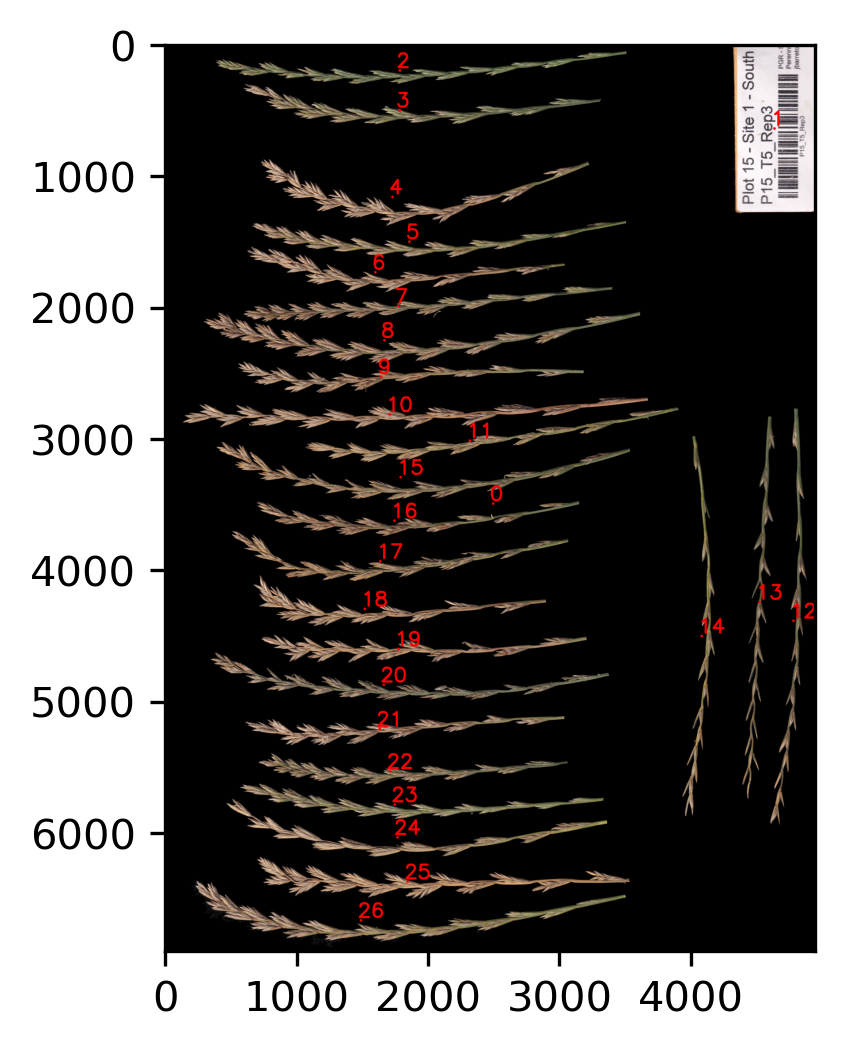

In [551]:
%%time
# Enumerate spikes
EnumerateSpkCV(bw0, rgb0, TextSize=5, TROE2020=False)

Wall time: 2.46 s


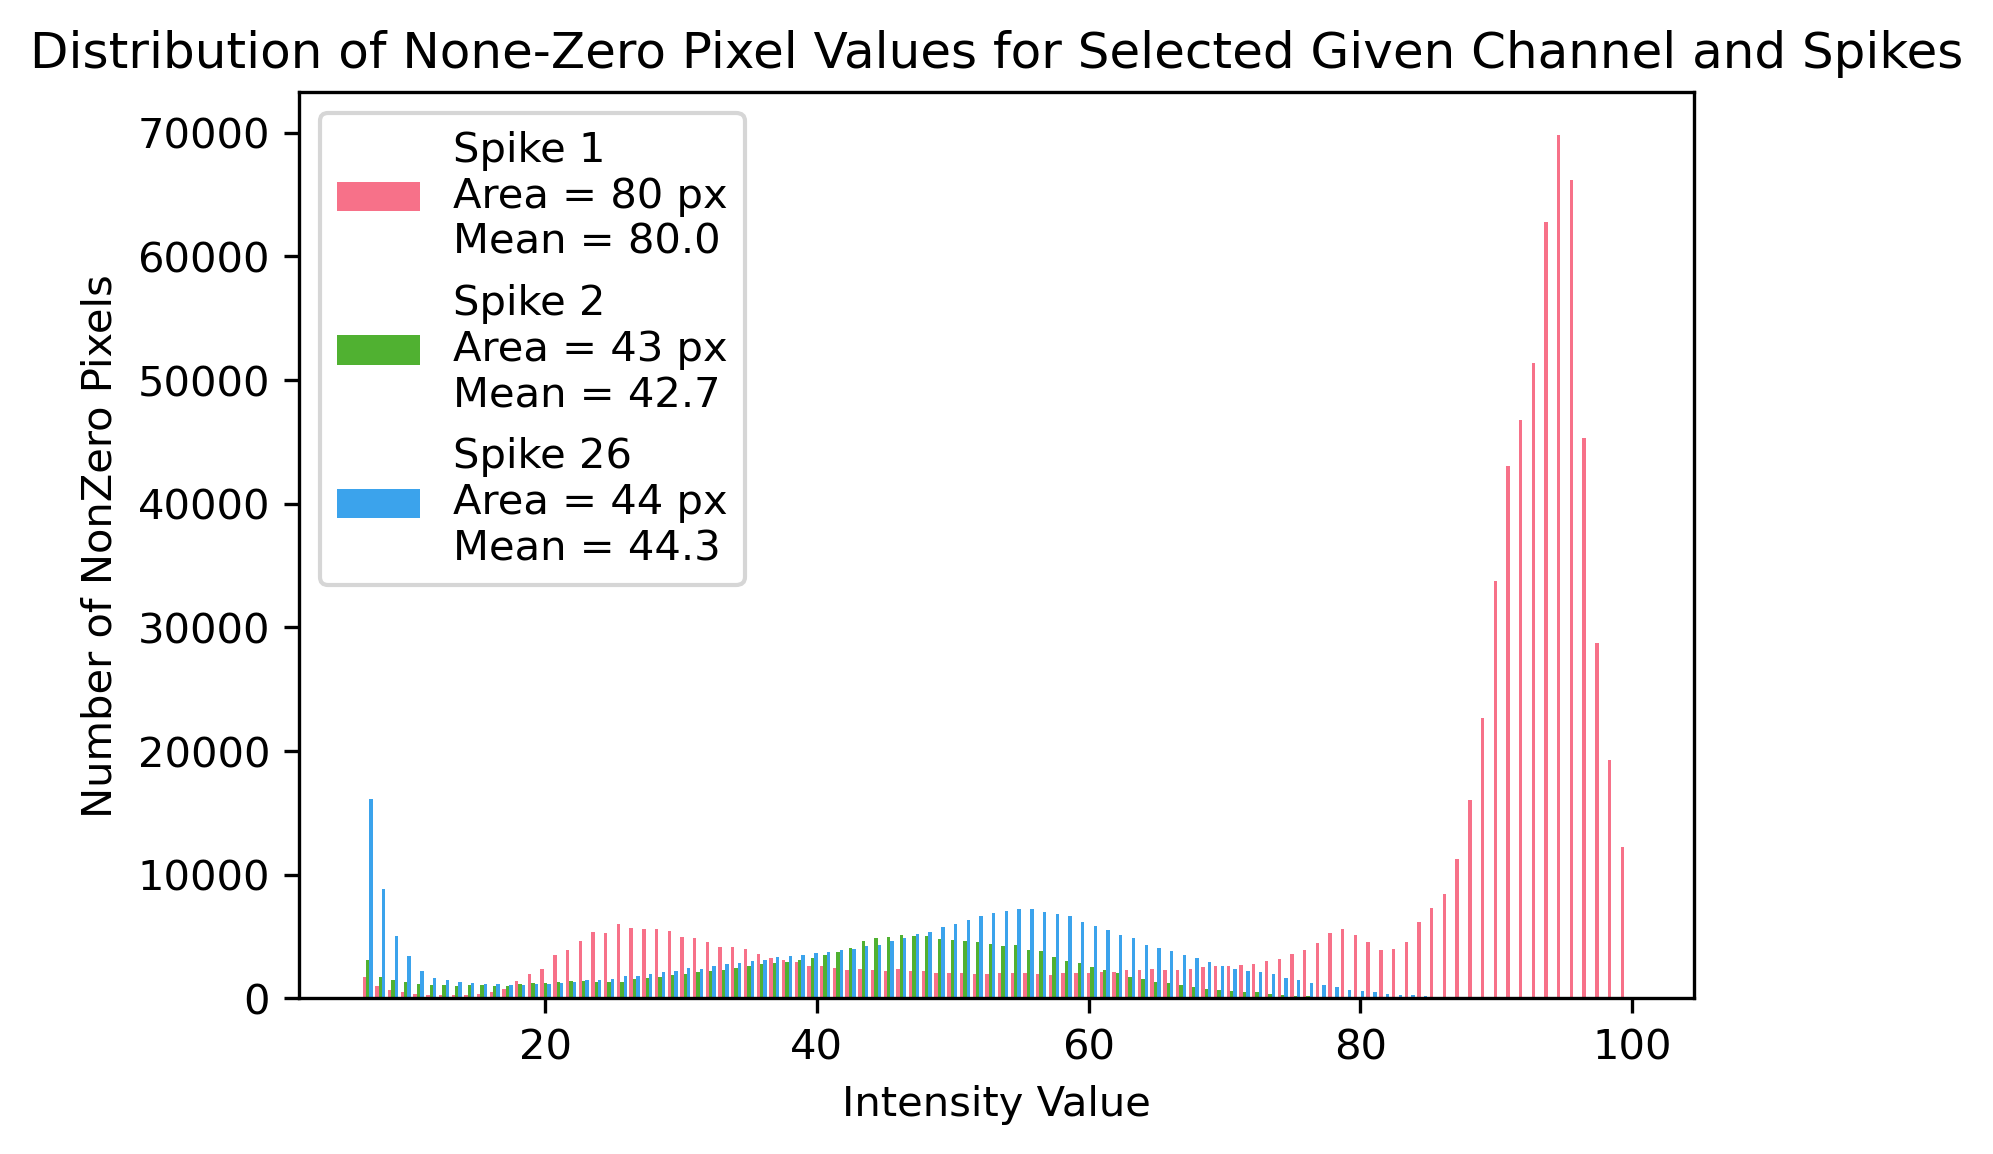

In [552]:
%%time
PixelHist(bw=bw0, Lab=lab0, channel = 0, spikes=[1,2,26], nbins = 100)

## Get spike properties

In [565]:
%%time
df = SpikesDF(I, ImagePath, RemoveBG=False, PrintSpkLabels=False)

Wall time: 7.35 s


In [566]:
%%time
df
# notice that the envelope (Spike_Label 1) was removed.

Wall time: 0 ns


,Image_Name,Spike_Label,Area,MajorAxis,MinorAxes,Orientation,Eccentricity,Perimeter,Red_mean,Red_min,...,b_Min_pos,b_Max_pos,b_p25_neg,b_p50_neg,b_p75_neg,b_Mean_neg,b_sd_neg,b_Min_neg,b_Max_neg,Circularity
1,S1p15T5R3.tif,2,171164,3407.838186,182.936824,-1.541404,0.998558,11409.010491,102.547709,6.0,...,0.000688,60.977533,-3.692663,-2.199361,-1.100855,-2.546597,8.279052,-26.968171,-0.000199,0.016524
2,S1p15T5R3.tif,3,186858,2939.056530,236.978101,1.552746,0.996744,11295.028781,113.373396,6.0,...,0.000097,59.866275,-3.980885,-2.455637,-1.186767,-2.816655,8.380863,-31.116419,-0.000074,0.018405
3,S1p15T5R3.tif,4,205301,2667.848608,461.766052,1.564827,0.984907,12245.488989,141.237593,11.0,...,0.000427,64.128089,-3.848296,-2.312250,-1.205388,-2.730999,7.671434,-28.250523,-0.000344,0.017205
4,S1p15T5R3.tif,5,179015,3029.514341,243.940255,-1.562132,0.996753,10657.489676,123.142016,11.0,...,0.000446,59.143414,-4.056798,-2.477840,-1.291503,-2.968408,8.820829,-25.280606,-0.000344,0.019806
5,S1p15T5R3.tif,6,167479,2520.798676,265.016392,1.530306,0.994458,10235.039928,135.509676,10.0,...,0.000566,64.309209,-3.556890,-2.178565,-1.158354,-2.524720,7.791695,-25.049626,-0.000344,0.020091
6,S1p15T5R3.tif,7,183784,3023.676784,118.150590,-1.503013,0.999236,11257.256270,117.813139,8.0,...,0.000566,59.463098,-3.826654,-2.290129,-1.159282,-2.667080,7.748279,-24.759876,-0.000344,0.018224
7,S1p15T5R3.tif,8,273762,3593.266539,346.717886,-1.562088,0.995334,14568.407999,125.897897,10.0,...,0.000446,55.280062,-3.762819,-2.217930,-1.127753,-2.578008,7.449325,-25.435384,-0.000450,0.016209
8,S1p15T5R3.tif,9,165747,2835.183993,168.517817,-1.543088,0.998232,10887.768896,130.550707,10.0,...,0.000054,59.011659,-3.382525,-2.058297,-1.111877,-2.414634,7.704650,-19.826031,-0.000074,0.017570
9,S1p15T5R3.tif,10,243291,3845.229317,152.785631,-1.542152,0.999210,15115.699413,138.388473,14.0,...,0.000815,62.189196,-3.410261,-2.070295,-1.127753,-2.397379,8.130727,-22.740855,-0.000199,0.013381
10,S1p15T5R3.tif,11,159902,3129.043839,161.718231,-1.455806,0.998664,9647.607245,129.185733,12.0,...,0.000815,60.653373,-3.439179,-2.172883,-1.197142,-2.444362,8.110512,-35.546599,-0.000552,0.021589


## Select a spike

Selected spike number 26
Wall time: 1.2 s


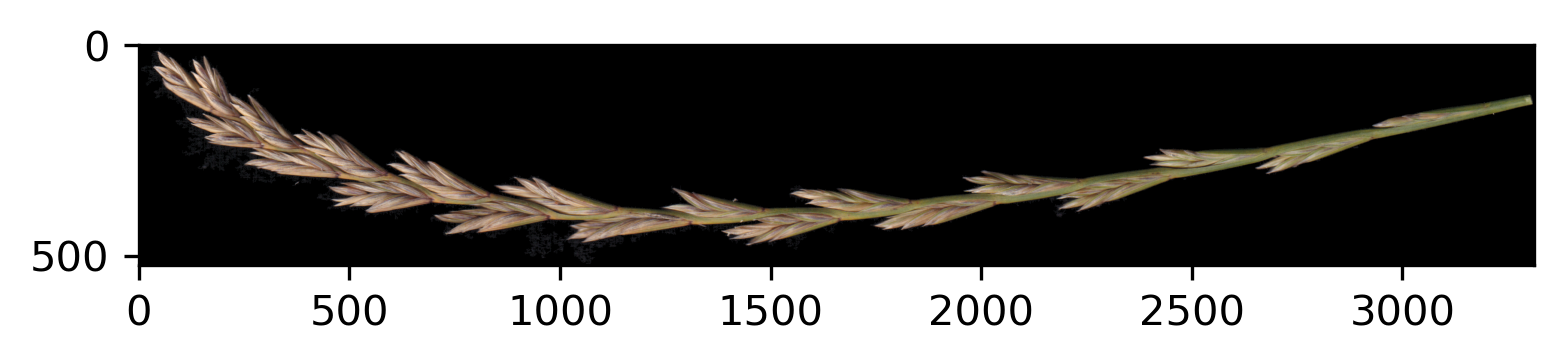

In [567]:
%%time
# Select a spike from the labeled image
Selected_Spike = 26
print("Selected spike number", Selected_Spike)

# Label spikes
labeled_spks, num_spikes = label(bw0, return_num = True)
spk = labeled_spks==Selected_Spike

# Crop spike
slice_x, slice_y = ndimage.find_objects(spk)[0]
cropped_spk = spk[slice_x, slice_y]
cropped_rgb = rgb0[slice_x, slice_y]
cropped_rgb = np.where(cropped_spk[..., None], cropped_rgb, 0)
cropped_gray = cropped_rgb @ [0.2126, 0.7152, 0.0722]
cropped_lab = color.rgb2lab(cropped_rgb)
cropped_hsv = color.rgb2hsv(cropped_rgb)

# Visualize selected spike
plt.imshow(cropped_rgb)

## Spike length

Wall time: 407 ms


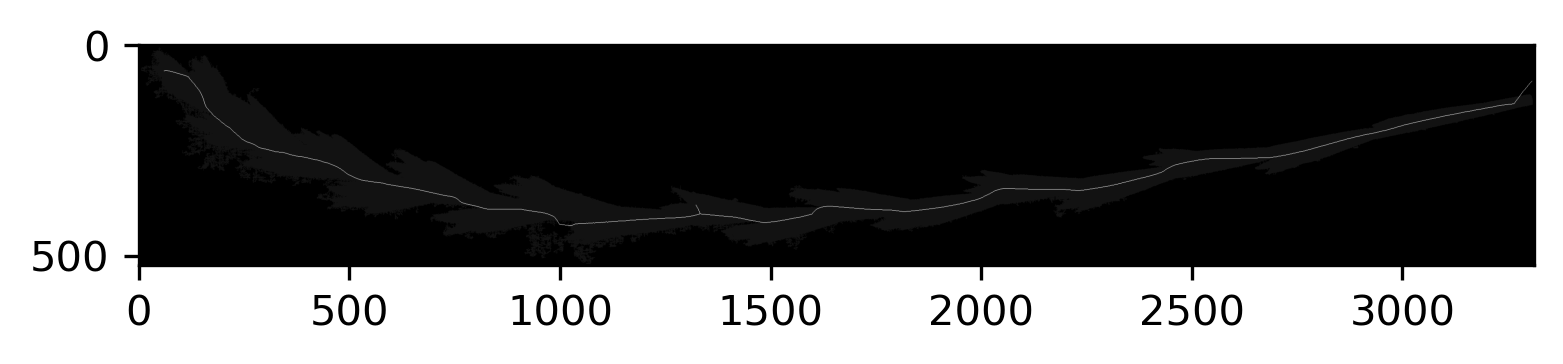

In [568]:
%%time
L = spk_length(cropped_spk, method='skelblur', Overlay=True, PlotCH=False)

## Threshold for contour detection

Wall time: 591 ms


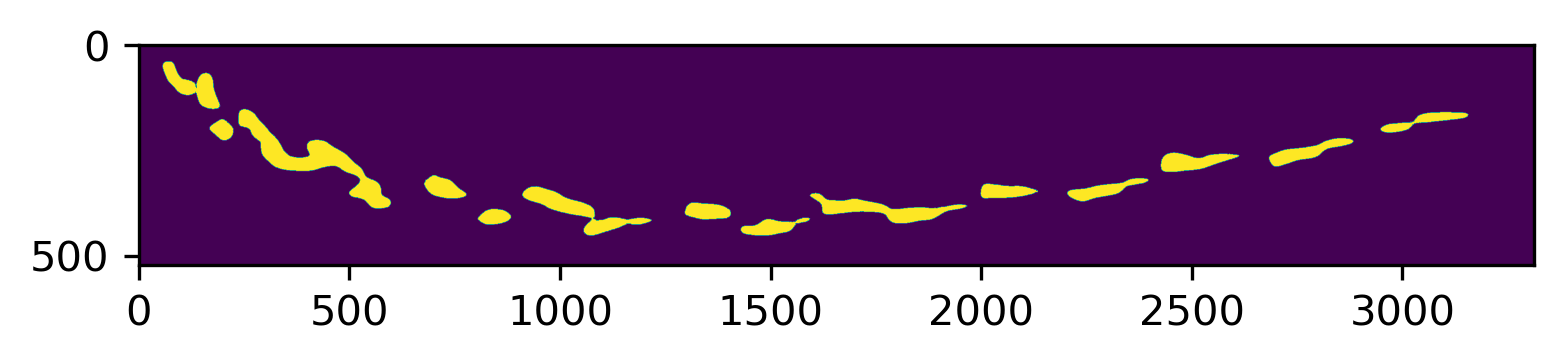

In [570]:
%%time
thresh2 = SpkltThresh(cropped=cropped_rgb, ResizeFactor=30, thr2=0.8, MinSize=1000)
plt.imshow(thresh2)

### Contour for spikelet detection

Detected spikeletes:  14
Wall time: 609 ms


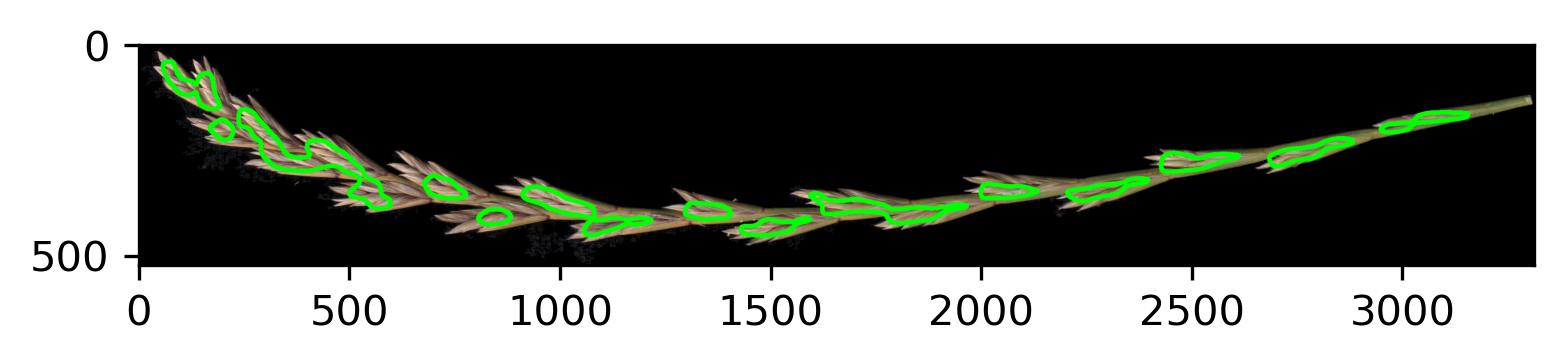

In [571]:
%%time
labels_cont = LabelContours(cropped_rgb, ResizeFactor=30, MinSize = 1000, thr2=0.8, plot=True)

### Get contour properties

Wall time: 0 ns
Detected spikeletes:  14


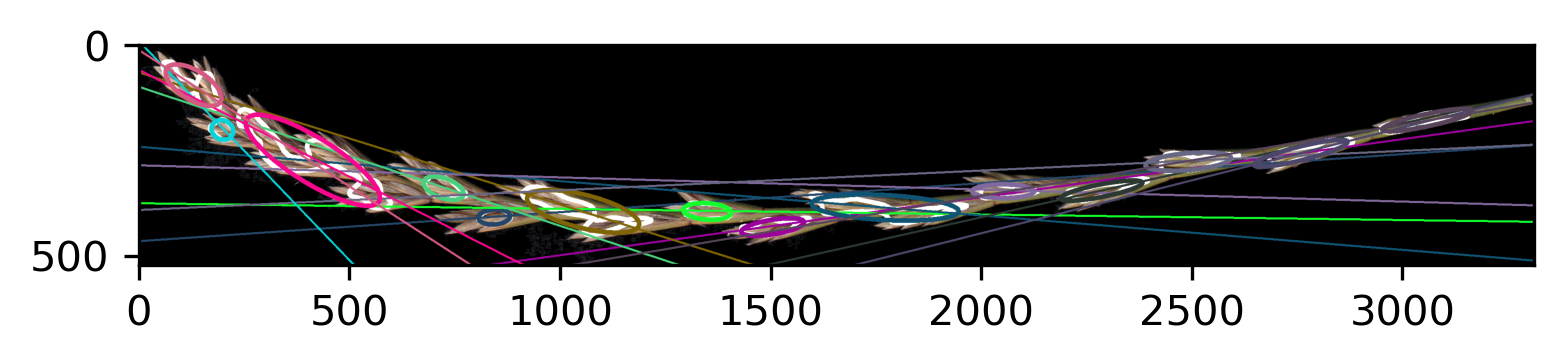

In [417]:
%time
SP = SpkltProps(cropped_rgb=cropped_rgb, ImagePath=img_name, ResizeFactor=30, MinSize = 1000, plot=True)

In [416]:
SP

,Image_Name,Spklt_Label,Area,MajorAxis,MinorAxes,Orientation,Eccentricity,Perimeter,Red_mean,Red_min,...,b_Max_pos,b_p25_neg,b_p50_neg,b_p75_neg,b_Mean_neg,b_sd_neg,b_Min_neg,b_Max_neg,Circularity,Spklt_Angle
0,S1p15T5R3.tif,1,6368,171.660568,65.222411,1.032844,0.925007,490.658946,162.031250,24.0,...,39.468770,-4.229800,-2.795579,-1.139976,-2.780006,7.132832,-10.988571,-0.003809,0.332394,0.137681
1,S1p15T5R3.tif,2,18712,451.921039,98.029712,1.112783,0.976190,1121.383910,160.108006,23.0,...,56.121207,-4.203711,-2.679019,-1.218738,-2.739496,8.105177,-8.259246,-0.003054,0.186991,0.068841
2,S1p15T5R3.tif,3,3638,232.644405,26.422243,-1.366281,0.993530,468.036580,133.103079,22.0,...,48.426112,-4.219624,-2.994298,-0.828456,-2.630061,6.872351,-5.090082,-0.133584,0.208695,-0.013285
3,S1p15T5R3.tif,4,1903,55.553328,44.373981,1.067745,0.601645,166.651804,158.153442,0.0,...,45.562458,-4.250785,-2.275547,-0.943826,-2.685925,6.930578,-8.035847,-0.032980,0.861050,-0.081522
4,S1p15T5R3.tif,5,5007,219.852303,32.391568,-1.310860,0.989087,461.705627,143.385061,0.0,...,46.034544,-2.675610,-1.842191,-1.009513,-1.969241,7.916935,-5.207184,-0.156357,0.295160,-0.313104
5,S1p15T5R3.tif,6,5246,189.508674,41.396941,-1.483115,0.975850,430.450793,145.793557,0.0,...,55.762551,-3.984604,-3.459294,-1.577937,-2.889118,8.089326,-4.493259,-0.135120,0.355788,-0.028684
6,S1p15T5R3.tif,7,3503,99.688042,45.703668,1.232816,0.888711,254.693434,163.480731,50.0,...,41.165497,-4.389362,-3.596322,-1.557154,-3.103560,7.716711,-9.366737,-0.023183,0.678601,0.222826
7,S1p15T5R3.tif,8,4168,198.006851,30.396294,-1.357319,0.988147,433.421356,136.441459,27.0,...,50.743640,-2.642823,-1.656398,-0.782673,-1.988606,8.726545,-5.238076,-0.012928,0.278816,-0.329710
8,S1p15T5R3.tif,9,3420,139.624128,32.992789,1.569356,0.971681,313.296465,144.580409,22.0,...,51.459901,-4.320203,-3.345824,-1.508330,-3.019610,9.246973,-8.196453,-0.003690,0.437850,0.046800
9,S1p15T5R3.tif,10,9568,314.657535,63.590541,1.231558,0.979366,790.984848,157.773934,40.0,...,57.539975,-4.395202,-2.966753,-1.072800,-2.894192,8.095725,-9.580341,-0.002739,0.192174,0.250906


### Distance between detected spikelets

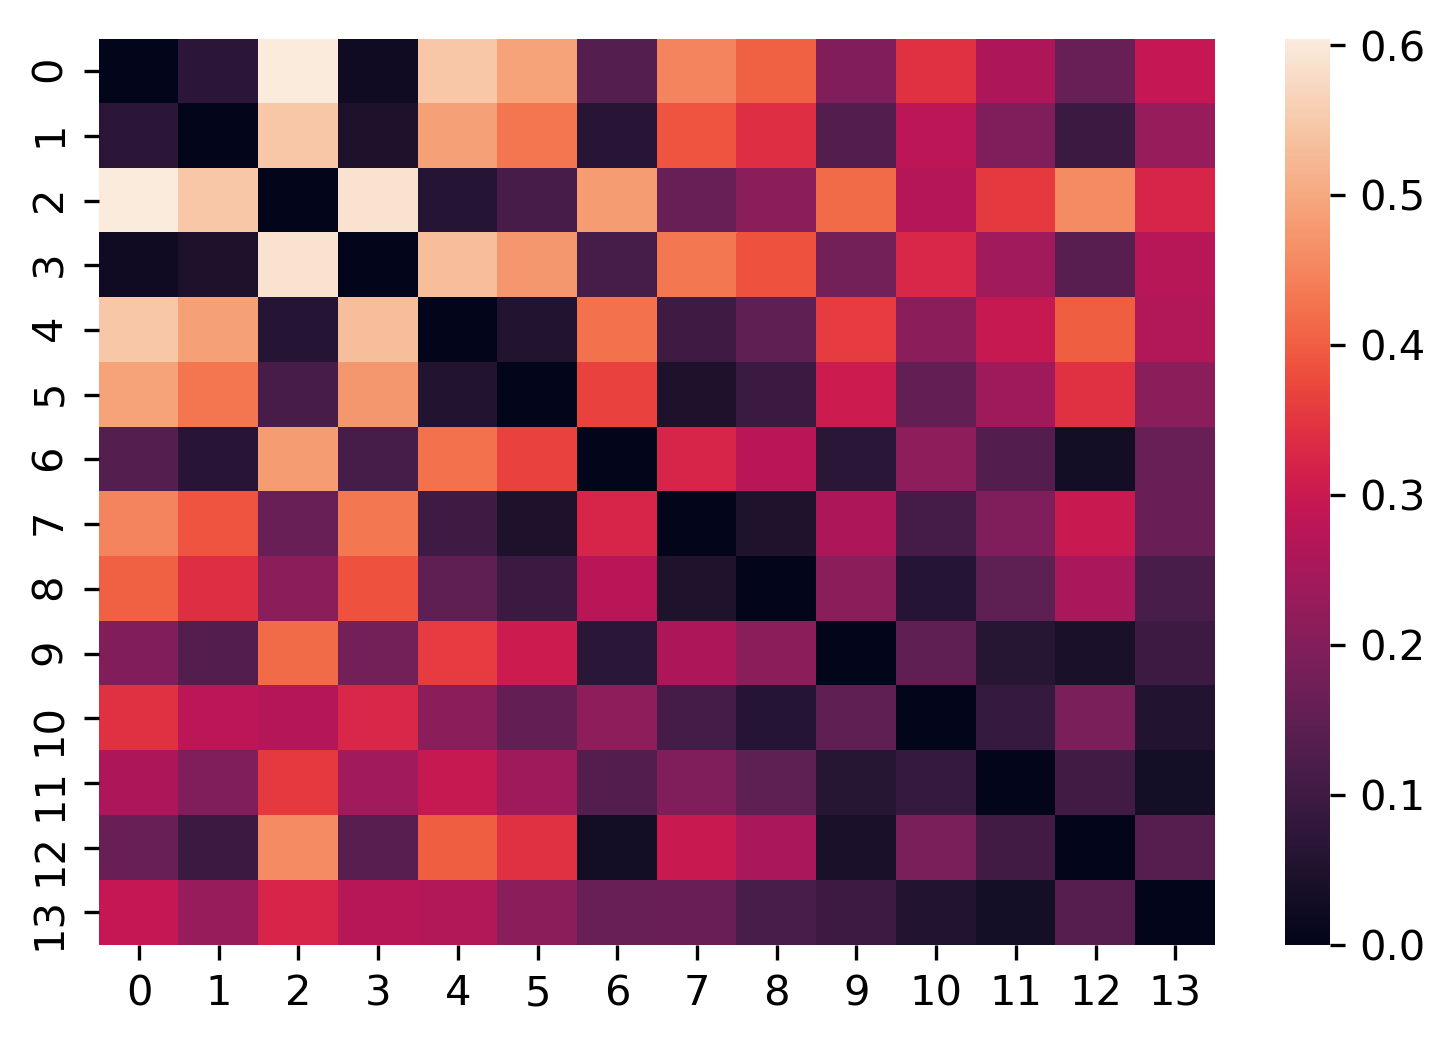

In [583]:
# Example:
D = DistAll(bw=thresh2, HeatMap=True, spike_length=SL)

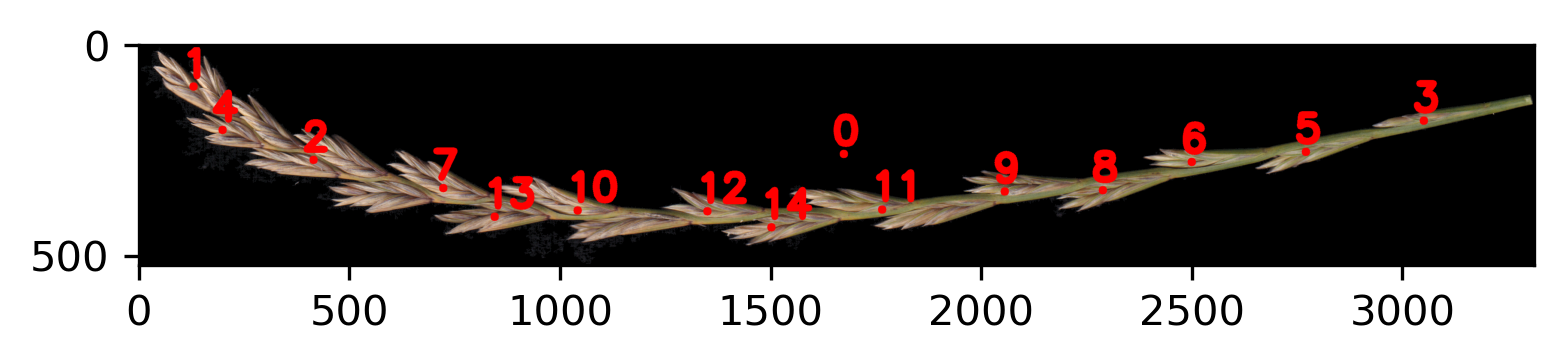

In [584]:
EnumerateSpkCV(thresh2, cropped_rgb, TextSize=3,  TROE2020=False)

## Watershed for spikelet detection

Detected spikelets =  18
Wall time: 574 ms


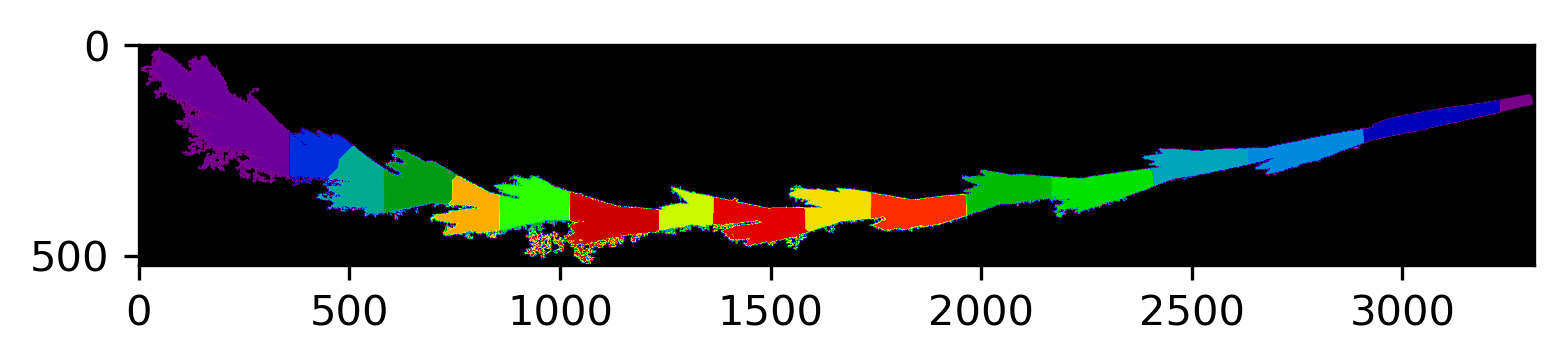

In [588]:
%%time
# Using watershed
spklts, n_spklts= LabelSpklts(cropped_rgb, MinDist=50, labels_out=True, n_spklt=True, Plot=True)

### Spikelet properties

In [576]:
%%time
Props = ObjProps(labeled=spklts, cropped_rgb=cropped_rgb, cropped_lab=cropped_lab, ImagePath=img_name, MinSize = 10000)

Wall time: 490 ms


In [578]:
Props
# Notice that the number of rows is lower. That's because the elements with that don't meet MinSize are removed.

,Image_Name,Spklt_Label,Area,MajorAxis,MinorAxes,Orientation,Eccentricity,Perimeter,Red_mean,Red_min,...,b_Min_pos,b_Max_pos,b_p25_neg,b_p50_neg,b_p75_neg,b_Mean_neg,b_sd_neg,b_Min_neg,b_Max_neg,Circularity
0,S1p15T5R3.tif,1,49225,419.631083,171.591575,0.867650,0.912574,6909.087117,116.453062,9.0,...,0.000427,57.762139,-3.223623,-2.190396,-1.316775,-2.452175,8.099205,-18.772897,-0.000855,0.012958
2,S1p15T5R3.tif,3,12375,365.036189,44.731674,-1.366903,0.992464,861.595021,109.914182,9.0,...,0.000815,55.396273,-4.034396,-2.192098,-1.048989,-2.758029,8.233594,-15.254454,-0.003216,0.209483
3,S1p15T5R3.tif,4,13606,151.620568,121.505537,-1.209130,0.598157,964.933116,134.856460,14.0,...,0.000815,56.121207,-3.342857,-2.134528,-1.127753,-2.425151,8.229373,-20.043606,-0.004130,0.183631
4,S1p15T5R3.tif,5,14375,303.296892,65.242223,-1.349349,0.976590,964.471175,119.257252,10.0,...,0.000815,51.278014,-3.299968,-2.016360,-0.952280,-2.583321,8.781900,-14.326230,-0.001171,0.194196
5,S1p15T5R3.tif,6,15839,155.879339,142.103812,0.318137,0.411019,1649.580915,127.305070,14.0,...,0.000811,57.906633,-3.364011,-2.190396,-1.279841,-2.535238,8.514928,-16.902386,-0.001846,0.073146
6,S1p15T5R3.tif,7,13626,261.022465,73.364595,-1.457000,0.959688,860.009235,123.259651,14.0,...,0.000815,55.762551,-3.614899,-2.424875,-1.223025,-2.603218,8.896299,-13.560739,-0.001846,0.231511
7,S1p15T5R3.tif,8,18055,180.247177,140.057613,-1.483312,0.629463,1216.880338,134.013016,15.0,...,0.000815,52.253352,-3.489223,-2.190396,-1.283244,-2.552039,8.231130,-21.374743,-0.002264,0.153219
8,S1p15T5R3.tif,9,16158,270.143083,83.728806,-1.385931,0.950755,1129.217388,115.957420,13.0,...,0.000760,50.743640,-3.300468,-2.193383,-1.271031,-2.483509,8.807170,-14.280179,-0.000127,0.159236
9,S1p15T5R3.tif,10,14443,229.253021,89.238723,-1.462531,0.921128,937.743253,119.137645,15.0,...,0.000815,51.459901,-3.937552,-2.378071,-1.328446,-2.723621,9.034544,-13.714007,-0.002037,0.206395
10,S1p15T5R3.tif,11,14145,151.037417,140.262391,1.115324,0.370932,1467.923015,121.241145,15.0,...,0.000815,52.565185,-3.302277,-2.252368,-1.482616,-2.511512,8.093352,-21.130838,-0.003396,0.082491


# Batch Execution

In [ ]:
path = r'./Images/TEST'
Images = ListImages(path, imgformat=".tif", recursive=False)


for img_name in Images:
    
    print("Processing image ", img_name)
    
    img_name = Images[0]
    # Remove background and create images
    I = RemoveBackground(img_name, OtsuScaling=0.25, rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
    rgb0 = I[0]
    gray0 = I[1]
    lab0 = I[2]
    hsv0 = I[3]
    bw0 = I[4]
    
    # Enumerate spikes
#     EnumerateSpkCV(bw0, rgb0, TextSize=5, TROE2020=False)

    # Collect spikes data
    df = SpikesDF(I=I, ImagePath=img_name, RemoveBG=False, PrintSpkLabels=False)

    # Label spikes
    labeled_spks, num_spikes = label(bw0, return_num = True)
    
    # Spike lengths
    SpkLengths = []
    
    # Spike distances from each other
    SpkDists = []

    spk_counter = 0
    for Label in labeled_spks:
        
        Label = labeled_spks[0]

        print("Processing spike ", spk_counter)
#         plt.imshow(labeled_spks==2)
        
        spk = labeled_spks==Label
    
        # Crop spike
        slice_x, slice_y = ndimage.find_objects(spk)[0]
        cropped_spk = spk[slice_x, slice_y]
        cropped_rgb = rgb0[slice_x, slice_y]
        cropped_rgb = np.where(cropped_spk[..., None], cropped_rgb, 0)
        cropped_gray = color.rgb2gray(cropped_rgb)
        cropped_lab = color.rgb2lab(cropped_rgb)
        cropped_hsv = color.rgb2hsv(cropped_rgb)
#         plt.imshow(thresh2)

        # Spike length
        sl = spk_length(cropped_spk, method='skelblur', Overlay=False, PlotCH=False)
        SpkLengths.append(sl)

        # Theshold for detection
        thresh2 = SpkltThresh(cropped=cropped_rgb, ResizeFactor=30, thr2=0.8, MinSize=1000)

        # Distances between contours
        D = DistAll(bw=thresh2, HeatMap=False, spike_length=sl)
        SpkDists.append(D)

        # Contours
        labels_cont = CountorProps(cropped_rgb, thresh2, ImagePath=img_name, ResizeFactor=30, MinSize = 1000, thr2=0.8, plot=False)
        Props = ObjProps(labeled=thresh2, cropped_rgb=cropped_rgb, cropped_lab=cropped_lab, ImagePath=img_name)

        # Watershed segments
        spklts, n_spklts= LabelSpklts(cropped_rgb, thresh2, MinDist=50, labels_out=True, n_spklt=True, Plot=False)
        WSProps = ObjProps(labeled=spklts, cropped_rgb=cropped_rgb, cropped_lab=cropped_lab, ImagePath=img_name, MinSize = 10000)

        spk_counter = spk_counter+1

# For one spike
# labeled_contours, num_contours = label(cropped_spk, return_num = True)
# red_props = regionprops(labeled_contours, intensity_image=cropped_rgb)
# Red_Perc = np.array(channel_percentiles(channel_props=red_props, Negatives=False)).T
# len(Red_Perc)
    